# Analyzing RSNA X-Ray Data with Convolutional Neural Networks

Carter Koehler

The primary purpose of this dataset is to determine a person's age based on their bone structure examined in an x-ray. The real value of this is determining how mature a person's skeleton is to determine if the patient has any perceptible growth defects, especially for children. For example, if a person's skeleton indicates that they should be 7 years old, but they are in fact 10, they are likely suffering from some sort of endocrine disorder. However, there are not many good quantitative measures for this, even fewer of which are fast and fully automated.

If a prediction algorithm were able to compute the age of a person's skeleton based on their x-ray data, that is enough to determine whether they are suffering from endocrine dysfunction.

This test does not need to be perfect, but it should do a reasonable job at predicting the presence or absence of endocrine dysfuntion. In particular, this form of testing should serve as a basic, first-pass screen, so that hospitals can save money on doing more costly, but more precise, tests on each individual. As a basic screening technique, when predicting whether or not someone's bones are inside or outside of the tolerable range of their age, we should prioritze decreasing the false negative rate to decreasing the false positive rate. It is always easier to run a patient through extra tests to find out that they aren't affected than it is to turn away a patient who is affected.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['axes.grid'] = True

import os
import sys
from pprint import pprint
from IPython.display import SVG

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.layers import Conv2D, MaxPooling2D, Reshape, BatchNormalization
from keras.models import Model
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import SGD, Adagrad, Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

Using TensorFlow backend.


## Data Preparation

In [2]:
file_dir = os.path.join(os.pardir, 'data')
compressed_dir = os.path.join(file_dir, 'boneage-compressed')

In [3]:
import pickle

boneage_data = np.array(pickle.load(open(os.path.join(compressed_dir, 'image_data.p'), 'rb')), dtype=int)

In [50]:
boneage_metadata = pd.read_csv(os.path.join(file_dir, 'boneage.csv')).iloc[:2000]

#convert from months to years
boneage_target = (boneage_metadata['boneage']/12).astype(int)
np.unique(boneage_target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

So, we have 20 "classes." One could argue that they would be better served as a continuous variable, but then CNN's would be harder to apply to the problem. Also, we'll take this opportunity to remove any classes which we don't have enough data to reasonabl make predictions from.

In [5]:
from skimage.io import imshow

# shamelessly stolen from https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb

def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        
        plt.imshow(images[i,:].reshape((h, w)), cmap='bone')
            
        plt.xticks(())
        plt.yticks(())
    plt.show()

In [6]:
from PIL import Image, ImageEnhance

img_dim = 256
boneage_df = boneage_data.copy()

for i in range(boneage_target.shape[0]):
    image = Image.fromarray(boneage_df[i,:].reshape(img_dim, img_dim).astype('uint8'))
    contr = ImageEnhance.Contrast(image).enhance(4)
    boneage_df[i,:] = np.array(contr).flatten()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

n_classes=len(np.unique(boneage_target))

boneage_df = StandardScaler().fit_transform(boneage_df)

X_train, X_test, y_train, y_test = train_test_split(boneage_df, 
                                                    boneage_target)

X_train = np.expand_dims(X_train.reshape((-1, img_dim, img_dim)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1, img_dim, img_dim)), axis=3)

y_train = to_categorical(y_train-1) # subtracting one because to_categorical is weird
y_test = to_categorical(y_test-1) 

/users/ckoehler/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Evaluation Metric

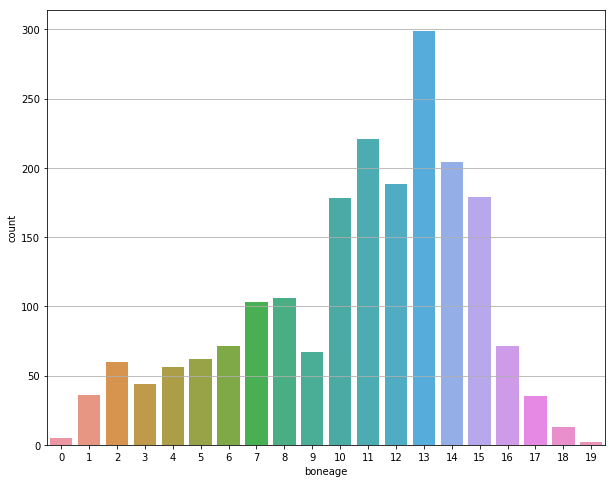

In [8]:
sns.countplot(boneage_target)
plt.show()

As addressed in the business case, we really care about minimizing the false negative rate of our predictive algorithm. To illustrate what precisely we care about, suppose a patient is given this screening process. Suppose then that the algorithm incorrectly gives their boneage to be something that it isn't, and the patient has to go through a couple other tests to find that they don't have some sort of endocrine dysfunction. Not much is lost here except a little bit of time. However, if the algorithm incorrectly predicts their bone age to be their actual age, this poses some serious problems.

This brings up the question of how to measure this hit/miss rate in the case of the data at hand, since we don't have both the bone age and actual age. However, it is almost certainly not very likely that the algorithm would incorrectly predict someone's bone age to be their actual age if there was a discrepancy. Thus, we are much more concerned with any given prediction being helpful than we are in picking up all of the examples of a given output class. Fortunately, precision scores measure for just this. 

As for addressing the issue of imbalanced classes, we note that we have the most instances of ages in late childhood and early adolescence. These ages are both young enough that endocrine disorders are more easily treatable and old enough that they might actually be detectable. So, conveniently, we have the most data on the classes we care most about. Because of this, we will use a micro-averaging scheme.

In [10]:
from sklearn.metrics import precision_score, confusion_matrix, make_scorer
avg_scheme = 'micro'
scorer = make_scorer(precision_score, average=avg_scheme)

## Cross-Validation Strategy

Due to our bevy of unbalanced classes, we will want to use a stratified cross-validation method to preserve class balance. As for the precise strategy, we should use k-fold, as the dataset isn't too large, and our algorithms should be able to manage it. 

In practice, the algorithm will usually be tasked with classifying an individual's age for a particular test. This is represented well by our CV strategy because, as previously mentioned, it should represent roughly the distribution of ages where this test is a concern.

We will tentatively try using 10 validation folds, unless that turns out to be too computationally expecnsive. In extreme cases, we may go to three.

In [11]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10)

## Image Augmentation

We would like to get our model to generalize well to unseen data, so let's include some perturbations of the images, so as not to train on identical data and overfit. 

First, let's get a rough idea of what kinds of variations we may see in the dataset and what might work well as augmentation strategies.

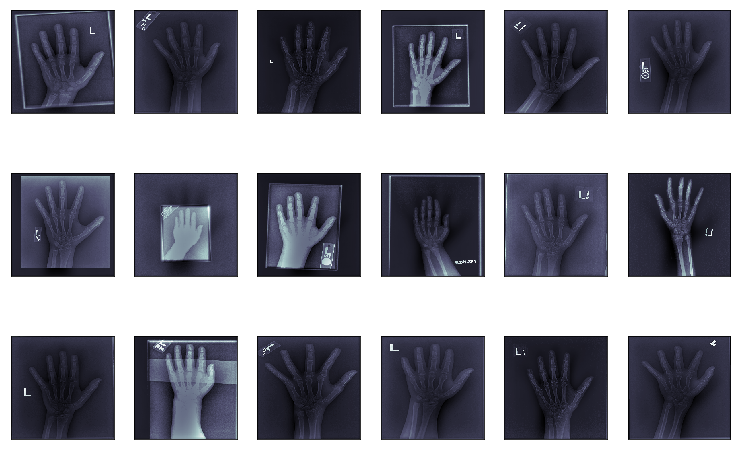

In [12]:
plot_gallery(boneage_df[np.random.choice(boneage_data.shape[0], 18), :], 256, 256)

Seeing some rotations within a few degrees here. The algorithm should also be robust to translations up to a quarter or so of the image. There are also horizontal flips and differences in scale which we should be able to deal with.

In [13]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0,
    zoom_range=0.1,
    fill_mode='nearest', #most of the time it's blank anyways
    cval=0,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(np.expand_dims(boneage_df.reshape((-1, img_dim, img_dim)), axis=3))

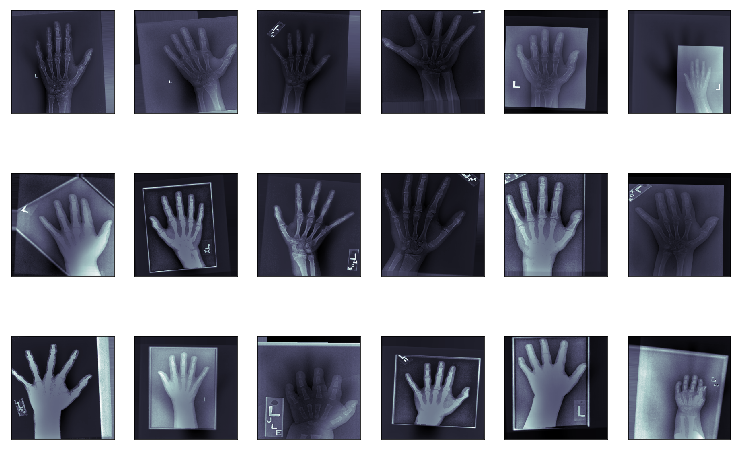

In [14]:
def plot_datagen(datagen, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    flow = datagen.flow(X_train, y_train, batch_size=n_row*n_col)
    
    for img in flow:
        for i in range(n_row * n_col):
            plt.subplot(n_row, n_col, i+1)
            plt.imshow(img[0][i].squeeze().reshape((h,w)), cmap='bone')
            plt.xticks(())
            plt.yticks(())
        break
    plt.show()
    
plot_datagen(datagen, 256, 256)

## Building Some Models

In [14]:
def plot_history(history):
    plt.figure()
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')

In [22]:
%%time

cnn_generic=Sequential()

cnn_generic.add(Conv2D(filters=64, 
                   input_shape=(img_dim, img_dim, 1), 
                   kernel_size=(3,3), 
                   padding='same', 
                   activation='relu'))
        
cnn_generic.add(MaxPooling2D(pool_size=(4,4), 
                             data_format='channels_last'))

cnn_generic.add(Dropout(rate=0.2))

cnn_generic.add(Conv2D(filters=32, 
#                    input_shape=(img_dim, img_dim, 1), 
                   kernel_size=(3,3), 
                   padding='same', 
                   activation='relu'))
        
cnn_generic.add(MaxPooling2D(pool_size=(4,4), 
                             data_format='channels_last'))

cnn_generic.add(Dropout(rate=0.2))

# cnn_generic.add(Conv2D(filters=16, 
# #                    input_shape=(img_dim, img_dim, 1), 
#                    kernel_size=(3,3), 
#                    padding='same', 
#                    activation='relu'))
        
# cnn_generic.add(MaxPooling2D(pool_size=(4,4), 
#                              data_format='channels_last'))

# cnn_generic.add(Dropout(rate=0.2))

cnn_generic.add(Flatten())

cnn_generic.add(Dense(units=64, 
                  activation='relu', 
                  kernel_initializer='he_uniform'))
cnn_generic.add(Dropout(rate=0.2))

cnn_generic.add(Dense(units=n_classes, 
                  activation='softmax', 
                  kernel_initializer='glorot_uniform'))
cnn_generic.add(Dropout(rate=0.2))

cnn_generic.compile(loss='categorical_crossentropy',
                   optimizer=RMSprop(lr=1e-6),
                   metrics=['acc'])

cnn_generic.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                             steps_per_epoch=int(X_train.shape[0]/32),
                             epochs=10, verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='loss', 
                                                      patience=3)])

Epoch 1/10
46/46 [==============================] - 10s 221ms/step - loss: 5.3322 - acc: 0.0543 - val_loss: 14.1931 - val_acc: 0.0303
Epoch 2/10
46/46 [==============================] - 10s 210ms/step - loss: 5.3624 - acc: 0.0634 - val_loss: 13.7814 - val_acc: 0.0364
Epoch 3/10
46/46 [==============================] - 10s 207ms/step - loss: 5.1926 - acc: 0.0805 - val_loss: 13.3881 - val_acc: 0.0343
Epoch 4/10
46/46 [==============================] - 10s 207ms/step - loss: 5.0901 - acc: 0.0714 - val_loss: 12.9673 - val_acc: 0.0404
Epoch 5/10
46/46 [==============================] - 10s 207ms/step - loss: 5.4224 - acc: 0.0771 - val_loss: 12.6283 - val_acc: 0.0485
Epoch 6/10
46/46 [==============================] - 9s 206ms/step - loss: 5.4288 - acc: 0.0821 - val_loss: 12.3008 - val_acc: 0.0586
Epoch 7/10
46/46 [==============================] - 10s 207ms/step - loss: 5.3938 - acc: 0.0954 - val_loss: 12.0264 - val_acc: 0.0687
CPU times: user 1min 19s, sys: 3.83 s, total: 1min 23s
Wall tim

In [23]:
cnn_generic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
__________

In [27]:
def predict_categ(model, data):
    return(np.argmax(model.predict(data), axis=1))

def evaluate_confusion(model, test_data, test_target, normalize=True, print_micro=True):
    target_int = np.argmax(test_target, axis=1)
    yhat = predict_categ(model, test_data)
    conf = confusion_matrix(target_int, yhat[:,np.newaxis])

    if normalize:
        conf = conf / np.unique(target_int, return_counts=True)[1][:, np.newaxis]
    if print_micro:
        print('Precision score of this model is {}'.format(precision_score(target_int, yhat, average='micro')))
        
    sns.heatmap(conf, annot=True)
    plt.show()

Precision score of this model is 0.06868686868686869


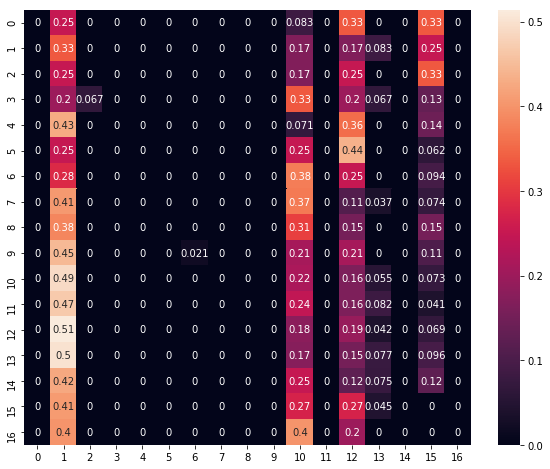

In [25]:
evaluate_confusion(cnn_generic, X_test, y_test)

A miserable failure. Not really sure what happened here.

In [25]:
%%time

cnn_fix=Sequential()

cnn_fix.add(Conv2D(filters=64, 
                   input_shape=(img_dim, img_dim, 1), 
                   kernel_size=(3,3), 
                   padding='same', 
                   kernel_initializer='he_uniform',
                   activation='relu'))
        
cnn_fix.add(MaxPooling2D(pool_size=(2,2), 
                         data_format='channels_last'))

cnn_fix.add(Conv2D(filters=32, 
                   kernel_size=(3,3), 
                   padding='same',  
                   kernel_initializer='he_uniform',
                   activation='relu'))
        
cnn_fix.add(MaxPooling2D(pool_size=(2,2), 
                         data_format='channels_last'))
cnn_fix.add(Dropout(rate=0.2))

cnn_fix.add(Flatten())

cnn_fix.add(Dense(units=64, 
                      activation='relu', 
                      kernel_initializer='he_uniform'))
cnn_fix.add(Dropout(rate=0.2))

cnn_fix.add(Dense(units=n_classes, 
                      activation='softmax', 
                      kernel_initializer='glorot_uniform'))
cnn_fix.add(Dropout(rate=0.2))

cnn_fix.compile(loss='categorical_crossentropy',
                       optimizer=RMSprop(lr=1e-6),
                       metrics=['acc'])

cnn_fix.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                             steps_per_epoch=int(X_train.shape[0]/64),
                             epochs=10,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='loss', 
                                                      patience=3)])

Epoch 1/10
23/23 [==============================] - 9s 411ms/step - loss: 5.4432 - acc: 0.0651 - val_loss: 2.7528 - val_acc: 0.1071
Epoch 2/10
23/23 [==============================] - 9s 384ms/step - loss: 5.3055 - acc: 0.1017 - val_loss: 2.6899 - val_acc: 0.1131
Epoch 3/10
23/23 [==============================] - 9s 376ms/step - loss: 5.2260 - acc: 0.1073 - val_loss: 2.6634 - val_acc: 0.1293
Epoch 4/10
23/23 [==============================] - 9s 378ms/step - loss: 5.2913 - acc: 0.1112 - val_loss: 2.6493 - val_acc: 0.1273
Epoch 5/10
23/23 [==============================] - 9s 378ms/step - loss: 5.1688 - acc: 0.1131 - val_loss: 2.6428 - val_acc: 0.1253
Epoch 6/10
23/23 [==============================] - 9s 377ms/step - loss: 5.1203 - acc: 0.1230 - val_loss: 2.6370 - val_acc: 0.1192
Epoch 7/10
23/23 [==============================] - 9s 377ms/step - loss: 5.1864 - acc: 0.1039 - val_loss: 2.6375 - val_acc: 0.1131
Epoch 8/10
23/23 [==============================] - 9s 376ms/step - loss: 5.

Precision score of this model is 0.1292929292929293


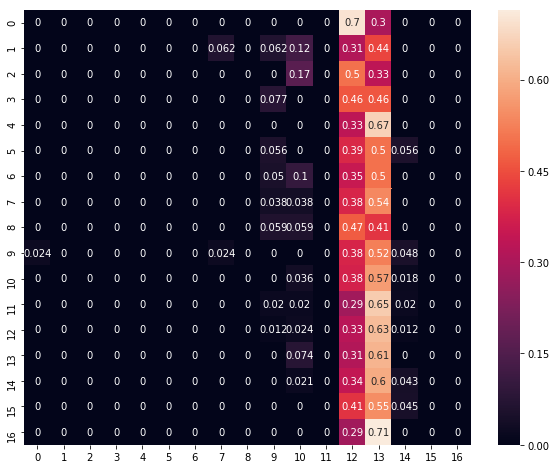

In [26]:
evaluate_confusion(cnn_fix, X_test, y_test)

## What Went Wrong

In [28]:
cnn_bare = Sequential()

# cnn_bare.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
# cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Conv2D(filters=16, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
# cnn_bare.add(Dropout(0.2))
cnn_bare.add(Flatten())
cnn_bare.add(Dense(units=64, activation='relu'))
# cnn_bare.add(Dropout(0.2))
cnn_bare.add(Dense(units=n_classes, activation='softmax'))

cnn_bare.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop',
                       metrics=['acc'])

history_bare = cnn_bare.fit(X_train, y_train, batch_size=1, epochs=10,
               validation_data=(X_test, y_test),
               callbacks=[EarlyStopping(monitor='loss', patience=3)])

# cnn_bare.fit_generator(datagen.flow(X_train, y_train, batch_size=16),
#                              steps_per_epoch=int(X_train.shape[0]/16),
#                              epochs=10,
#                              verbose=1,
#                              validation_data=(X_test, y_test),
#                              callbacks=[EarlyStopping(monitor='loss', 
#                                                       patience=3)])

Train on 1485 samples, validate on 495 samples
Epoch 1/10
1485/1485 [==============================] - 10s 6ms/step - loss: 3.7929 - acc: 0.1185 - val_loss: 2.6832 - val_acc: 0.1677
Epoch 2/10
1485/1485 [==============================] - 9s 6ms/step - loss: 2.6800 - acc: 0.1468 - val_loss: 2.6144 - val_acc: 0.1677
Epoch 3/10
1485/1485 [==============================] - 9s 6ms/step - loss: 2.6413 - acc: 0.1455 - val_loss: 2.5997 - val_acc: 0.1657
Epoch 4/10
1485/1485 [==============================] - 9s 6ms/step - loss: 2.6077 - acc: 0.1508 - val_loss: 2.6100 - val_acc: 0.1657
Epoch 5/10
1485/1485 [==============================] - 9s 6ms/step - loss: 2.5915 - acc: 0.1569 - val_loss: 2.5738 - val_acc: 0.1697
Epoch 6/10
1485/1485 [==============================] - 9s 6ms/step - loss: 2.4888 - acc: 0.1811 - val_loss: 2.6855 - val_acc: 0.1556
Epoch 7/10
1485/1485 [==============================] - 9s 6ms/step - loss: 2.3156 - acc: 0.2586 - val_loss: 2.7532 - val_acc: 0.1192
Epoch 8/10
148

Precision score of this model is 0.7966329966329966


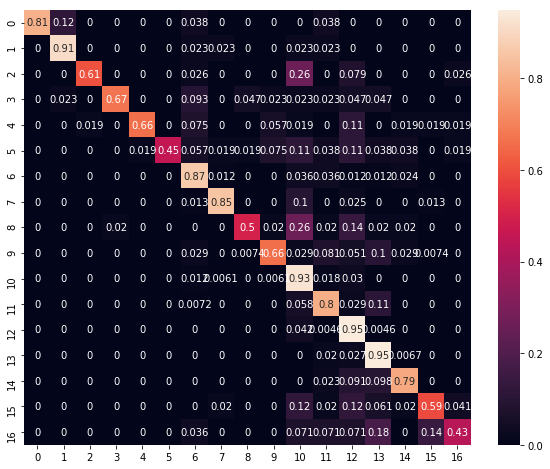

Precision score of this model is 0.15353535353535352


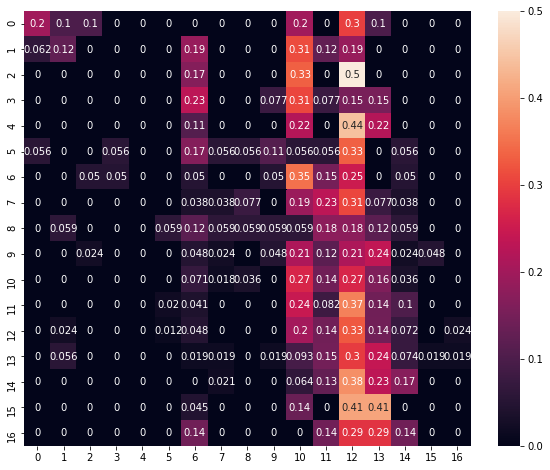

In [29]:
evaluate_confusion(cnn_bare, X_train, y_train)
evaluate_confusion(cnn_bare, X_test, y_test)

In [89]:
cnn_bare = Sequential()

# cnn_bare.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
# cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Conv2D(filters=16, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
# cnn_bare.add(Dropout(0.2))
cnn_bare.add(Flatten())
cnn_bare.add(Dense(units=64, activation='relu'))
# cnn_bare.add(Dropout(0.2))
cnn_bare.add(Dense(units=n_classes, activation='softmax'))

cnn_bare.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop',
                       metrics=['acc'])

# history_bare = cnn_bare.fit(X_train, y_train, batch_size=1, epochs=10,
#                validation_data=(X_test, y_test),
#                callbacks=[EarlyStopping(monitor='loss', patience=3)])

cnn_bare.fit_generator(datagen.flow(X_train, y_train, batch_size=16),
                             steps_per_epoch=int(X_train.shape[0]/16),
                             epochs=10,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='loss', 
                                                      patience=3)])

Epoch 1/10
92/92 [==============================] - 9s 100ms/step - loss: 6.0097 - acc: 0.1223 - val_loss: 2.7205 - val_acc: 0.1414
Epoch 2/10
92/92 [==============================] - 9s 99ms/step - loss: 2.6963 - acc: 0.1414 - val_loss: 2.7312 - val_acc: 0.1414
Epoch 3/10
92/92 [==============================] - 9s 98ms/step - loss: 2.6531 - acc: 0.1391 - val_loss: 2.6379 - val_acc: 0.1354
Epoch 4/10
92/92 [==============================] - 9s 98ms/step - loss: 2.6208 - acc: 0.1428 - val_loss: 2.6584 - val_acc: 0.1192
Epoch 5/10
92/92 [==============================] - 9s 98ms/step - loss: 2.5942 - acc: 0.1578 - val_loss: 2.6506 - val_acc: 0.1333
Epoch 6/10
92/92 [==============================] - 9s 97ms/step - loss: 2.5809 - acc: 0.1579 - val_loss: 2.6008 - val_acc: 0.1556
Epoch 7/10
92/92 [==============================] - 9s 98ms/step - loss: 2.5569 - acc: 0.1623 - val_loss: 2.6437 - val_acc: 0.1535
Epoch 8/10
92/92 [==============================] - 9s 98ms/step - loss: 2.5546 - 

Precision score of this model is 0.1872053872053872


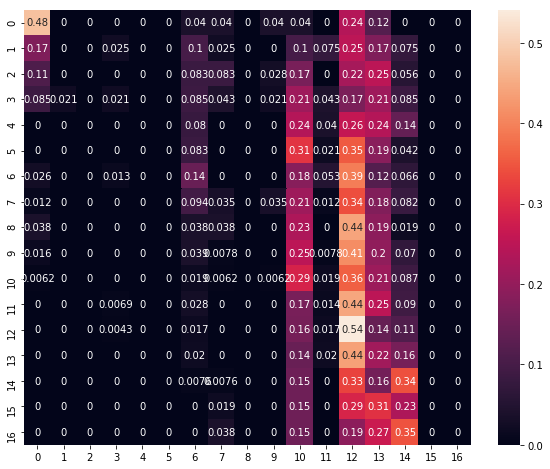

Precision score of this model is 0.1393939393939394


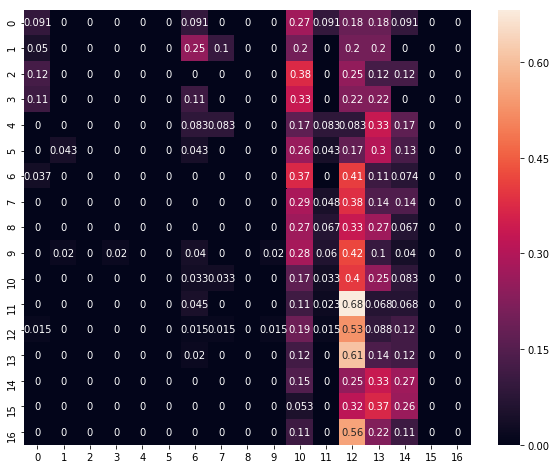

In [90]:
evaluate_confusion(cnn_bare, X_train, y_train)
evaluate_confusion(cnn_bare, X_test, y_test)

In [92]:
cnn_bare = Sequential()

# cnn_bare.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
# cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Conv2D(filters=16, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Dropout(0.2))
cnn_bare.add(Flatten())
cnn_bare.add(Dense(units=64, activation='relu'))
cnn_bare.add(Dropout(0.2))
cnn_bare.add(Dense(units=n_classes, activation='softmax'))

cnn_bare.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop',
                       metrics=['acc'])

history_bare = cnn_bare.fit(X_train, y_train, batch_size=1, epochs=10,
               validation_data=(X_test, y_test),
               callbacks=[EarlyStopping(monitor='loss', patience=3)])

# cnn_bare.fit_generator(datagen.flow(X_train, y_train, batch_size=16),
#                              steps_per_epoch=int(X_train.shape[0]/16),
#                              epochs=10,
#                              verbose=1,
#                              validation_data=(X_test, y_test),
#                              callbacks=[EarlyStopping(monitor='loss', 
#                                                       patience=3)])

Train on 1485 samples, validate on 495 samples
Epoch 1/10
1485/1485 [==============================] - 11s 7ms/step - loss: 2.8445 - acc: 0.1320 - val_loss: 2.6969 - val_acc: 0.1354
Epoch 2/10
1485/1485 [==============================] - 10s 7ms/step - loss: 2.6108 - acc: 0.1582 - val_loss: 2.6658 - val_acc: 0.1293
Epoch 3/10
1485/1485 [==============================] - 10s 7ms/step - loss: 2.5409 - acc: 0.1933 - val_loss: 2.7355 - val_acc: 0.1192
Epoch 4/10
1485/1485 [==============================] - 10s 7ms/step - loss: 2.4185 - acc: 0.2579 - val_loss: 2.8510 - val_acc: 0.1414
Epoch 5/10
1485/1485 [==============================] - 10s 7ms/step - loss: 2.2283 - acc: 0.3286 - val_loss: 3.3191 - val_acc: 0.1212
Epoch 6/10
1485/1485 [==============================] - 10s 7ms/step - loss: 1.9688 - acc: 0.4431 - val_loss: 3.4384 - val_acc: 0.1111
Epoch 7/10
1485/1485 [==============================] - 10s 7ms/step - loss: 1.6565 - acc: 0.5374 - val_loss: 3.6912 - val_acc: 0.1091
Epoch 8/

Precision score of this model is 0.9373737373737374


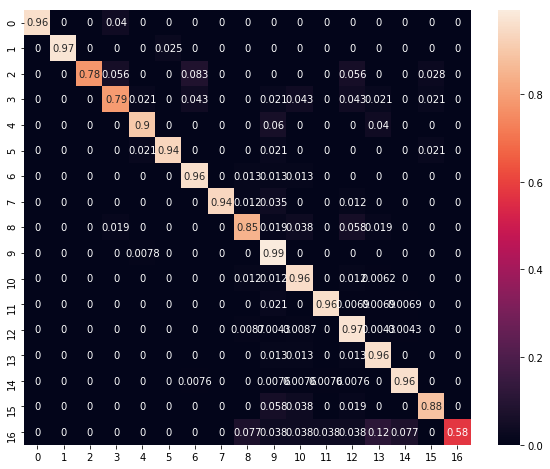

Precision score of this model is 0.10303030303030303


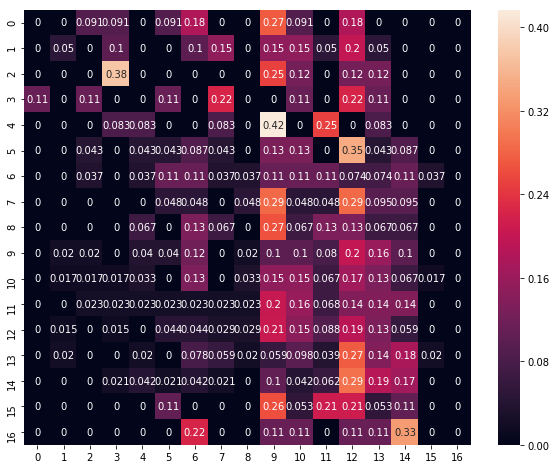

In [93]:
evaluate_confusion(cnn_bare, X_train, y_train)
evaluate_confusion(cnn_bare, X_test, y_test)

In [94]:
cnn_bare = Sequential()

# cnn_bare.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
# cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Conv2D(filters=16, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Dropout(0.2))
cnn_bare.add(Flatten())
cnn_bare.add(Dense(units=64, activation='relu'))
cnn_bare.add(Dropout(0.2))
cnn_bare.add(Dense(units=n_classes, activation='softmax'))

cnn_bare.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop',
                       metrics=['acc'])

# history_bare = cnn_bare.fit(X_train, y_train, batch_size=1, epochs=10,
#                validation_data=(X_test, y_test),
#                callbacks=[EarlyStopping(monitor='loss', patience=3)])

cnn_bare.fit_generator(datagen.flow(X_train, y_train, batch_size=16),
                             steps_per_epoch=int(X_train.shape[0]/16),
                             epochs=10,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='loss', 
                                                      patience=3)])

Epoch 1/10
92/92 [==============================] - 9s 101ms/step - loss: 3.3131 - acc: 0.1347 - val_loss: 2.8090 - val_acc: 0.1354
Epoch 2/10
92/92 [==============================] - 9s 100ms/step - loss: 2.7975 - acc: 0.1491 - val_loss: 2.7767 - val_acc: 0.1374
Epoch 3/10
92/92 [==============================] - 9s 99ms/step - loss: 2.7743 - acc: 0.1486 - val_loss: 2.7596 - val_acc: 0.1374
Epoch 4/10
92/92 [==============================] - 9s 98ms/step - loss: 2.7588 - acc: 0.1447 - val_loss: 2.7395 - val_acc: 0.1394
Epoch 5/10
92/92 [==============================] - 9s 98ms/step - loss: 2.7318 - acc: 0.1440 - val_loss: 2.7217 - val_acc: 0.1354
Epoch 6/10
92/92 [==============================] - 9s 98ms/step - loss: 2.7072 - acc: 0.1547 - val_loss: 2.6752 - val_acc: 0.1374
Epoch 7/10
92/92 [==============================] - 9s 98ms/step - loss: 2.6699 - acc: 0.1506 - val_loss: 2.6506 - val_acc: 0.1354ss: 2.6744 - acc: 0.1
Epoch 8/10
92/92 [==============================] - 9s 98ms/

Precision score of this model is 0.1622895622895623


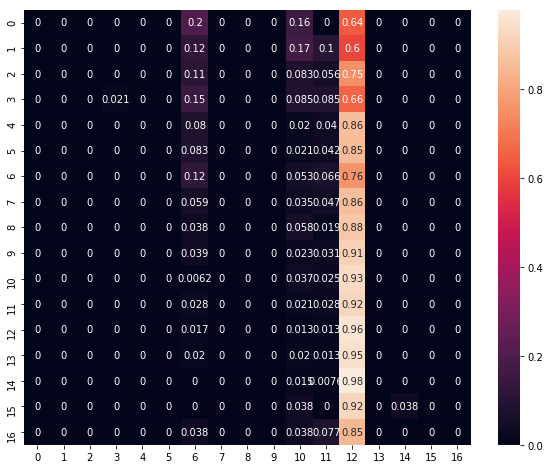

Precision score of this model is 0.13737373737373737


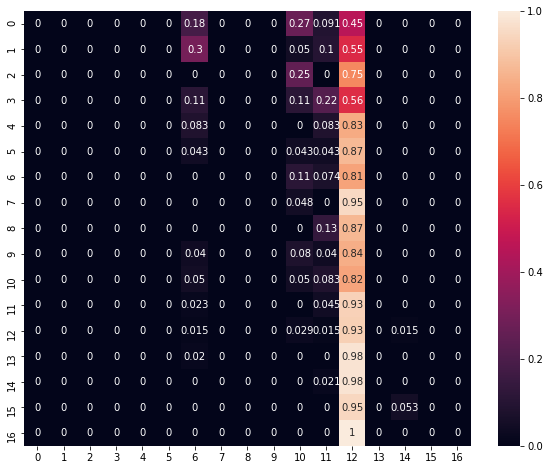

In [95]:
evaluate_confusion(cnn_bare, X_train, y_train)
evaluate_confusion(cnn_bare, X_test, y_test)

In [54]:
cnn_low_dim = Sequential()

cnn_low_dim.add(Conv2D(filters=64, 
                       kernel_size=(4,4), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform'
                      ))
cnn_low_dim.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_low_dim.add(Dropout(0.2))

cnn_low_dim.add(Conv2D(filters=16, 
                       kernel_size=(3,3), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform'
                      ))
cnn_low_dim.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_low_dim.add(Dropout(0.2))

cnn_low_dim.add(Conv2D(filters=8, 
                       kernel_size=(2,2), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform'
                      ))
cnn_low_dim.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_low_dim.add(Dropout(0.2))

cnn_low_dim.add(Flatten())

cnn_low_dim.add(Dense(units=64, activation='relu', kernel_initializer='he_uniform'))
cnn_low_dim.add(Dropout(0.2))
# cnn_low_dim.add(Dense(units=64, activation='relu', kernel_initializer='he_uniform'))
# cnn_low_dim.add(Dropout(0.2))
# cnn_low_dim.add(Dense(units=64, activation='relu', kernel_initializer='he_uniform'))
# cnn_low_dim.add(Dropout(0.2))

cnn_low_dim.add(Dense(units=n_classes, activation='softmax', kernel_initializer='glorot_uniform'))

cnn_low_dim.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['acc'])

# history_bare = cnn_bare.fit(X_train, y_train, batch_size=1, epochs=10,
#                validation_data=(X_test, y_test),
#                callbacks=[EarlyStopping(monitor='loss', patience=3)])

history_low_dim = cnn_low_dim.fit_generator(datagen.flow(X_train, y_train, batch_size=1),
                             steps_per_epoch=int(X_train.shape[0]/1),
                             epochs=10,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='val_loss', 
                                                      patience=3)])

Epoch 1/10
1485/1485 [==============================] - 12s 8ms/step - loss: 2.7635 - acc: 0.1246 - val_loss: 2.6895 - val_acc: 0.1677
Epoch 2/10
1485/1485 [==============================] - 11s 8ms/step - loss: 2.6694 - acc: 0.1428 - val_loss: 2.6139 - val_acc: 0.1677
Epoch 3/10
1485/1485 [==============================] - 11s 8ms/step - loss: 2.6618 - acc: 0.1455 - val_loss: 2.6001 - val_acc: 0.1677
Epoch 4/10
1485/1485 [==============================] - 11s 7ms/step - loss: 2.6556 - acc: 0.1455 - val_loss: 2.5971 - val_acc: 0.1677
Epoch 5/10
1485/1485 [==============================] - 11s 7ms/step - loss: 2.6611 - acc: 0.1455 - val_loss: 2.5977 - val_acc: 0.1677
Epoch 6/10
1485/1485 [==============================] - 11s 7ms/step - loss: 2.6522 - acc: 0.1455 - val_loss: 2.6024 - val_acc: 0.1677
Epoch 7/10
1485/1485 [==============================] - 11s 7ms/step - loss: 2.6604 - acc: 0.1455 - val_loss: 2.6022 - val_acc: 0.1677


In [55]:
cnn_low_dim.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 253, 253, 64)      1088      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 61, 61, 16)        9232      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 8)         520       
__________

Precision score of this model is 0.14545454545454545


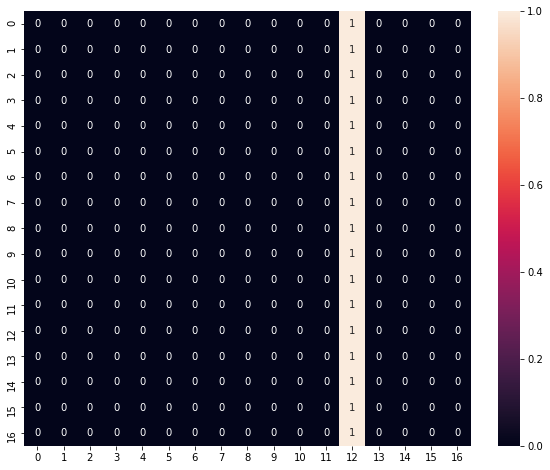

Precision score of this model is 0.16767676767676767


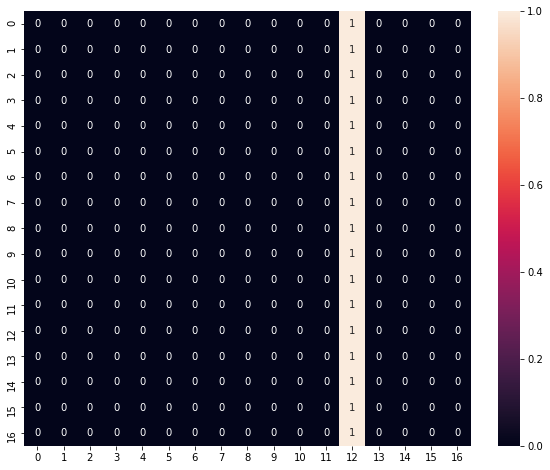

In [56]:
evaluate_confusion(cnn_low_dim, X_train, y_train)
evaluate_confusion(cnn_low_dim, X_test, y_test)

## As a Regression Problem

It seems no matter what we do to alter the structure of the neural network, it is going to persist in getting things wrong and guessing the mode. Perhaps we could reframe the problem as a regression and try to see if we can get better performance by leveraging the nearly-continuous nature of the output data. This will require altering the data a little.

In [44]:
cnns = {}

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

n_classes=len(np.unique(boneage_target))

boneage_df = StandardScaler().fit_transform(boneage_df)

X_train, X_test, y_train, y_test = train_test_split(boneage_df, 
                                                    boneage_target)

X_train = np.expand_dims(X_train.reshape((-1, img_dim, img_dim)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1, img_dim, img_dim)), axis=3)

y_scale = StandardScaler().fit(y_train.values.reshape(-1,1))
y_train = y_scale.transform(y_train.values.reshape(-1,1))
y_test = y_scale.transform(y_test.values.reshape(-1,1))

/users/ckoehler/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [53]:
cnn_reg = Sequential()

cnn_reg.add(Conv2D(filters=64, 
                       kernel_size=(4,4), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform'
                      ))
cnn_reg.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_reg.add(Dropout(0.2))

cnn_reg.add(Conv2D(filters=16, 
                       kernel_size=(3,3), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform'
                      ))
cnn_reg.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_reg.add(Dropout(0.2))

cnn_reg.add(Conv2D(filters=8, 
                       kernel_size=(2,2), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform'
                      ))
cnn_reg.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_reg.add(Dropout(0.2))

cnn_reg.add(Flatten())

cnn_reg.add(Dense(units=64, activation='relu', kernel_initializer='he_uniform'))
cnn_reg.add(Dropout(0.2))

cnn_reg.add(Dense(units=1, activation='linear', kernel_initializer='glorot_uniform'))

cnn_reg.compile(loss='mse',
                optimizer='adam')

history_reg = cnn_reg.fit_generator(datagen.flow(X_train, y_train, batch_size=1),
                             steps_per_epoch=int(X_train.shape[0]/1),
                             epochs=10,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='val_loss', 
                                                      patience=3)])

Epoch 1/10
1500/1500 [==============================] - 12s 8ms/step - loss: 1.3830 - val_loss: 0.9316
Epoch 2/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9788 - val_loss: 0.8682
Epoch 3/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9006 - val_loss: 0.8328
Epoch 4/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8686 - val_loss: 0.8367
Epoch 5/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8405 - val_loss: 1.1906
Epoch 6/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8091 - val_loss: 0.8468


In [54]:
cnn_reg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 253, 253, 64)      1088      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 84, 84, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 84, 84, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 82, 82, 16)        9232      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 27, 27, 16)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 26, 26, 8)         520       
__________

In [57]:
def plot_history_reg(history):
    plt.figure()
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.title('Training')
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')    
    
    plt.subplot(1,2,2)
    plt.plot(history.history['val_loss'])
    plt.title('Validation')
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')
    
    plt.show()
    

def plot_regression(model, X_pred, y_true, history=None):
    y_pred = y_scale.inverse_transform(model.predict(X_pred).flatten())
    y_target = y_scale.inverse_transform(y_true.flatten())
    
    plt.figure()
    plt.scatter(y_target, y_pred, color='r', label='predictions')
    plt.plot(y_target, y_target, 'b', label='goal')
    plt.xlabel('Actual Value (years)')
    plt.ylabel('Predicted Value (years)')
    plt.legend(loc='best')
    plt.title('Actual Vs. Predicted')
    plt.show()

    resid = y_target - y_pred
    plt.figure()
    plt.scatter(y_target, resid, color='r', label='residuals')
    plt.plot(y_target, y_target - y_target, 'b', label='goal')
    plt.ylabel('Residuals (years)')
    plt.xlabel('Actual Value')
    plt.title('Residuals')
    plt.legend(loc='best')
    plt.show()
    
    if history is not None:
         plot_history_reg(history)

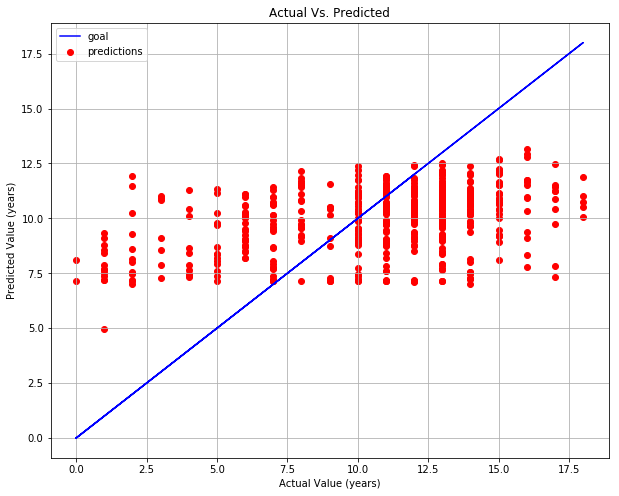

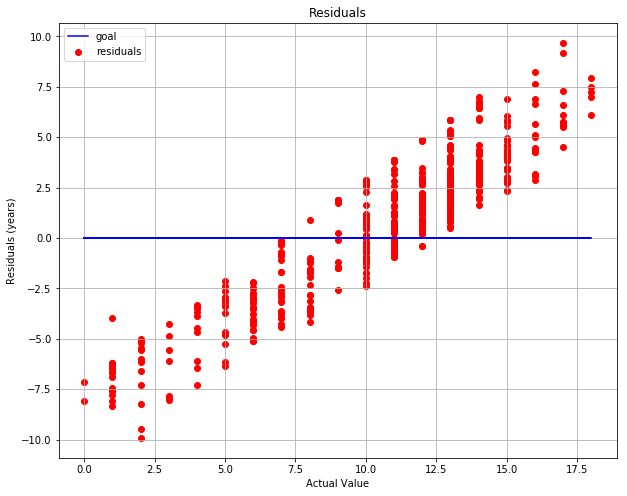

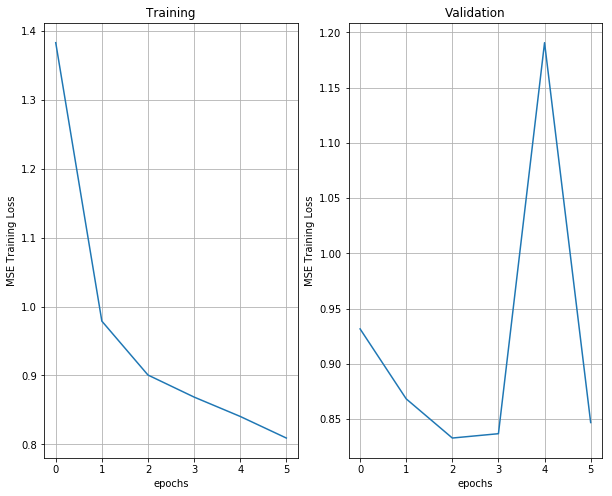

In [59]:
plot_regression(cnn_reg, X_test, y_test, history=history_reg)
cnns.update({'reg': cnn_reg})

This seems to work much better. There is still a bias towards towards the modes, but this is to be expected with a model that uses a regression metric. Regardless, most predictions fall within a few years of their actual value. We'll now take the time to update our proposed evaluation schemes and goals.

We will now need to use some sort of regression metric. Mean-squared-error will likely work well for our purposes, as we care more about correcting estimations which are particularly far away than perfecting estimations which are already close.

10-fold Stratified Cross Validation will nolonger work for the dataset, as stratification is no longer necessary, and can lead to overly-deterministic test sets due to the small number of instances at particular classes and the continuous nature of the output. We will instead use standard 10-fold CV.

We will test the model against a comparable MLP to determine whether or not CNNs bring much utility to this application.

Let's get back to it!

In [26]:
from sklearn.model_selection import KFold

## Tuning the Regressor

In [27]:
cnn_reg_tune = Sequential()

cnn_reg_tune.add(Conv2D(filters=64, 
                       kernel_size=(4,4), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform'
                      ))
cnn_reg_tune.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_reg_tune.add(Dropout(0.2))

cnn_reg_tune.add(Conv2D(filters=16, 
                       kernel_size=(3,3), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform'
                      ))
cnn_reg_tune.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_reg_tune.add(Dropout(0.2))

cnn_reg_tune.add(Flatten())

cnn_reg_tune.add(Dense(units=64, activation='relu', kernel_initializer='he_uniform'))
cnn_reg_tune.add(Dropout(0.2))

cnn_reg_tune.add(Dense(units=1, activation='linear', kernel_initializer='glorot_uniform'))

cnn_reg_tune.compile(loss='mse',
                       optimizer='rmsprop')

history_reg_tune = cnn_reg_tune.fit_generator(datagen.flow(X_train, y_train, batch_size=1),
                             steps_per_epoch=int(X_train.shape[0]/1),
                             epochs=10,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='val_loss', 
                                                      min_delta=0.01,
                                                      patience=3)])

Epoch 1/10
1500/1500 [==============================] - 11s 8ms/step - loss: 1.6264 - val_loss: 0.8750
Epoch 2/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9708 - val_loss: 0.9113
Epoch 3/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9322 - val_loss: 0.9248
Epoch 4/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9831 - val_loss: 0.8737


In [28]:
cnn_reg_tune.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 253, 253, 64)      1088      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 84, 84, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 84, 84, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 82, 82, 16)        9232      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 27, 27, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 27, 27, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11664)             0         
__________

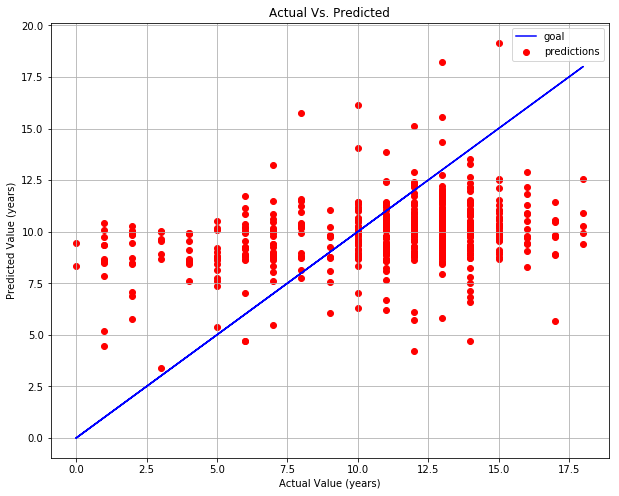

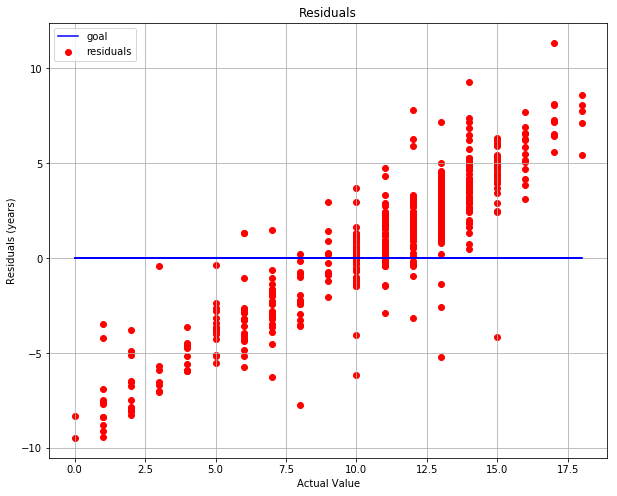

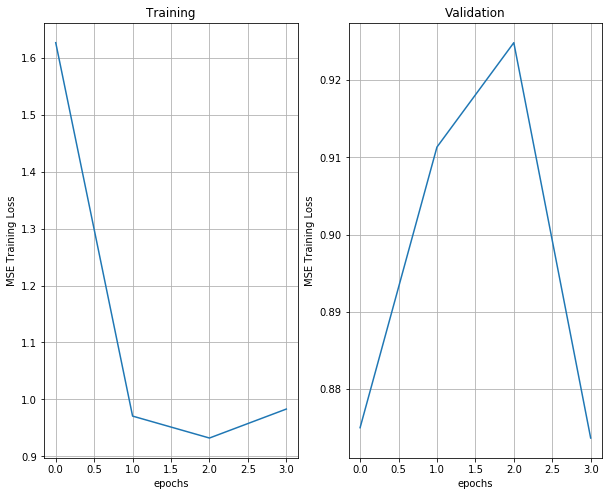

In [58]:
plot_regression(cnn_reg_tune, X_test, y_test, history=history_reg_tune)
cnns.update({'tune' : cnn_reg_tune})

This isn't much better than the previous model. We'll try another configuration and start running them for more epochs.

Additionally, one problems, which might not be immediately apparent from the the finished notebook, is that we have been having issues with certain runs getting stuck in what appears to be a local optimum. In this next attempt, we will also try different initialization strategies.

### New Strategies

In [30]:
l2_reg = 1e-6

In [31]:
cnn_reg_new = Sequential()

cnn_reg_new.add(Conv2D(filters=64, 
                       kernel_size=(4,4), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_new.add(MaxPooling2D((4,4), data_format='channels_last'))
cnn_reg_new.add(Dropout(0.2))

cnn_reg_new.add(Conv2D(filters=16, 
                       kernel_size=(3,3),
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_new.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_reg_new.add(Dropout(0.2))

cnn_reg_new.add(Flatten())

cnn_reg_new.add(Dense(units=64, 
                      activation='relu', 
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_reg)
                     ))
cnn_reg_new.add(Dropout(0.2))
cnn_reg_new.add(Dense(units=16, 
                      activation='relu', 
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_reg)
                     ))
cnn_reg_new.add(Dropout(0.2))

cnn_reg_new.add(Dense(units=1, activation='linear', kernel_initializer='glorot_normal'))

cnn_reg_new.compile(loss='mse',
                       optimizer='adam')

history_reg_new = cnn_reg_new.fit_generator(datagen.flow(X_train, y_train, batch_size=1),
                             steps_per_epoch=int(X_train.shape[0]/1),
                             epochs=30,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='val_loss',
                                                      min_delta=0.01,
                                                      patience=4)])

Epoch 1/30
1500/1500 [==============================] - 11s 8ms/step - loss: 1.0463 - val_loss: 0.8887
Epoch 2/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9829 - val_loss: 0.8144
Epoch 3/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9177 - val_loss: 0.7959
Epoch 4/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9058 - val_loss: 1.0091
Epoch 5/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8555 - val_loss: 0.7759
Epoch 6/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8616 - val_loss: 0.7105
Epoch 7/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8283 - val_loss: 0.7690
Epoch 8/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8180 - val_loss: 0.7114
Epoch 9/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8111 - val_loss: 0.7051
Epoch 10/30
1500/1500 [==============================] - 11s 7ms/step - l

In [32]:
cnn_reg_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 253, 253, 64)      1088      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 16)        9232      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 20, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6400)              0         
__________

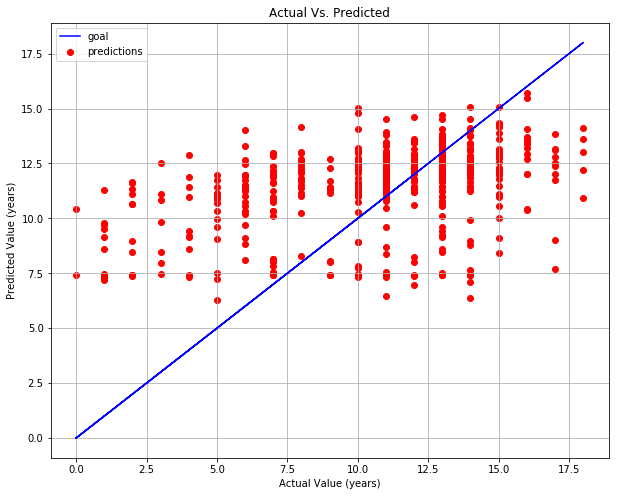

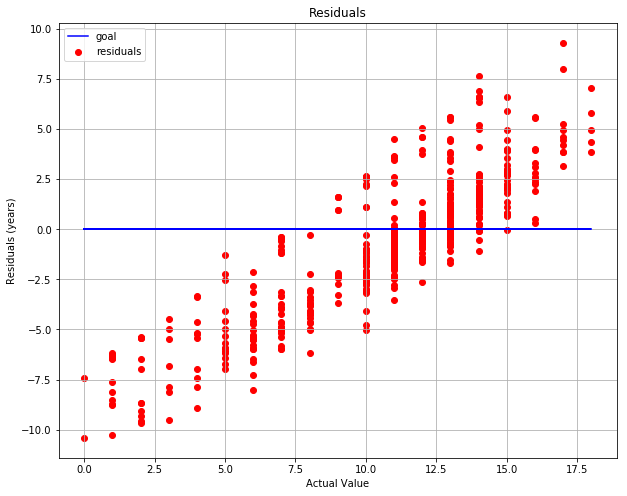

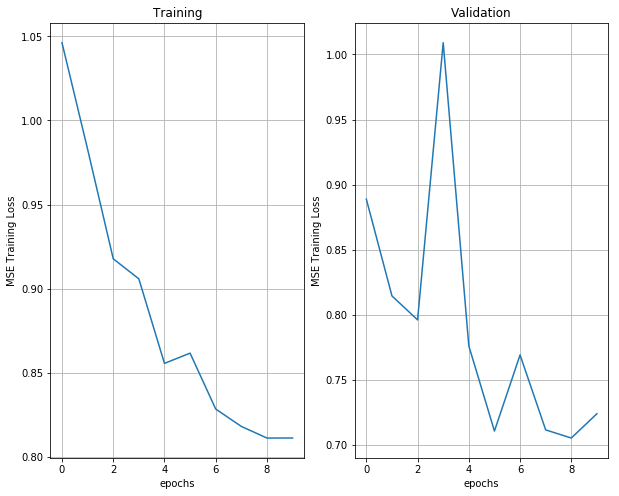

In [60]:
plot_regression(cnn_reg_new, X_test, y_test, history=history_reg_new)
cnns.update({'new' : cnn_reg_new})

This model looks to be doing about as well as the earlier ones. We may need to mess around with parameters a little bit to improve it.

In [34]:
cnn_reg_new_1 = Sequential()

cnn_reg_new_1.add(Conv2D(filters=64, 
                       kernel_size=(3,3), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_new_1.add(MaxPooling2D((4,4), data_format='channels_last'))
cnn_reg_new_1.add(Dropout(0.2))

cnn_reg_new_1.add(Conv2D(filters=64, 
                       kernel_size=(3,3),
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_new_1.add(MaxPooling2D((4,4), data_format='channels_last'))
cnn_reg_new_1.add(Dropout(0.2))

cnn_reg_new_1.add(Flatten())

cnn_reg_new_1.add(Dense(units=64, 
                      activation='relu', 
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_reg)
                     ))
cnn_reg_new_1.add(Dropout(0.2))
cnn_reg_new_1.add(Dense(units=32, 
                      activation='relu', 
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_reg)
                     ))
cnn_reg_new_1.add(Dropout(0.2))

cnn_reg_new_1.add(Dense(units=1, activation='linear', kernel_initializer='glorot_normal'))

cnn_reg_new_1.compile(loss='mse',
                       optimizer='rmsprop')

history_reg_new_1 = cnn_reg_new_1.fit_generator(datagen.flow(X_train, y_train, batch_size=1),
                             steps_per_epoch=int(X_train.shape[0]/1),
                             epochs=30,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='val_loss',
                                                      min_delta=0.01,
                                                      patience=4)])

Epoch 1/30
1500/1500 [==============================] - 11s 8ms/step - loss: 2.7975 - val_loss: 0.8328
Epoch 2/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9459 - val_loss: 0.8028
Epoch 3/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8760 - val_loss: 0.7029
Epoch 4/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8241 - val_loss: 0.6984
Epoch 5/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.7652 - val_loss: 0.7692
Epoch 6/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.7412 - val_loss: 0.6433
Epoch 7/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.7616 - val_loss: 0.6677
Epoch 8/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.7391 - val_loss: 0.6877
Epoch 9/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.7194 - val_loss: 0.6111
Epoch 10/30
1500/1500 [==============================] - 11s 7ms/step - l

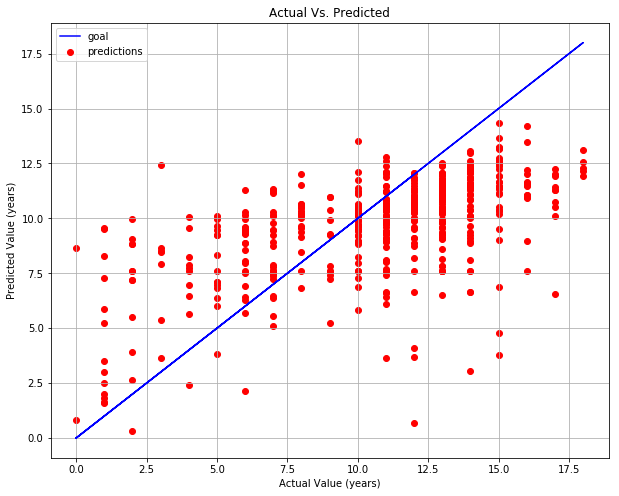

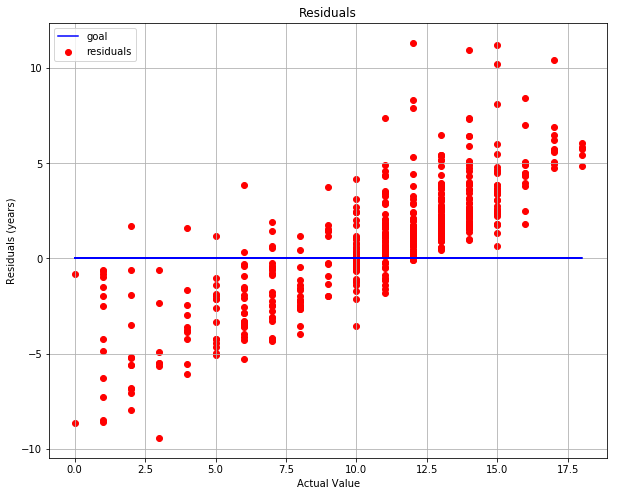

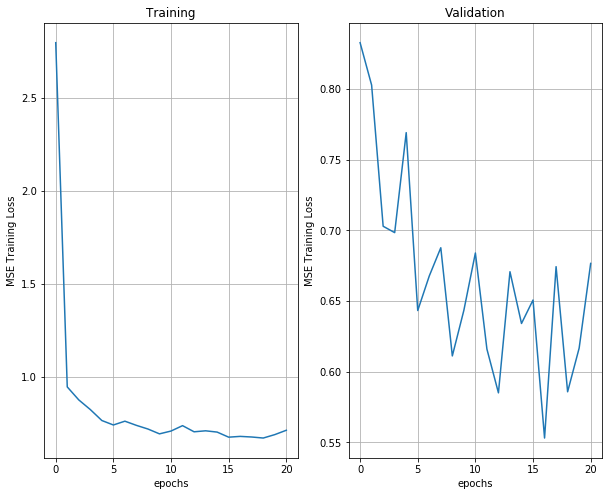

In [61]:
plot_regression(cnn_reg_new_1, X_test, y_test, history=history_reg_new_1)
cnns.update({'new1' : cnn_reg_new_1})

In [36]:
cnn_reg_new_2 = Sequential()

cnn_reg_new_2.add(Conv2D(filters=64, 
                       kernel_size=(3,3), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_new_2.add(MaxPooling2D((4,4), data_format='channels_last'))
cnn_reg_new_2.add(Dropout(0.2))

cnn_reg_new_2.add(Conv2D(filters=64, 
                       kernel_size=(3,3),
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_new_2.add(MaxPooling2D((4,4), data_format='channels_last'))
cnn_reg_new_2.add(Dropout(0.2))

cnn_reg_new_2.add(Conv2D(filters=8, 
                       kernel_size=(3,3),
                       activation='relu',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_new_2.add(MaxPooling2D((4,4), data_format='channels_last'))
cnn_reg_new_2.add(Dropout(0.2))

cnn_reg_new_2.add(Flatten())

cnn_reg_new_2.add(Dense(units=64, 
                      activation='relu', 
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_reg)
                     ))
cnn_reg_new_2.add(Dropout(0.2))
cnn_reg_new_2.add(Dense(units=32, 
                      activation='relu', 
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_reg)
                     ))
cnn_reg_new_2.add(Dropout(0.2))

cnn_reg_new_2.add(Dense(units=1, activation='linear', kernel_initializer='glorot_normal'))

cnn_reg_new_2.compile(loss='mse',
                       optimizer='rmsprop')

history_reg_new_2 = cnn_reg_new_2.fit_generator(datagen.flow(X_train, y_train, batch_size=1),
                             steps_per_epoch=int(X_train.shape[0]/1),
                             epochs=30,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='val_loss',
                                                      min_delta=0.01,
                                                      patience=4)])

Epoch 1/30
1500/1500 [==============================] - 11s 7ms/step - loss: 1.1571 - val_loss: 0.8697
Epoch 2/30
1500/1500 [==============================] - 11s 7ms/step - loss: 1.0076 - val_loss: 0.8145
Epoch 3/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9608 - val_loss: 0.7612
Epoch 4/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9574 - val_loss: 0.7443
Epoch 5/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9330 - val_loss: 0.9442
Epoch 6/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9068 - val_loss: 0.7497
Epoch 7/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.9121 - val_loss: 0.6853
Epoch 8/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8939 - val_loss: 0.6766
Epoch 9/30
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8653 - val_loss: 0.6872
Epoch 10/30
1500/1500 [==============================] - 11s 7ms/step - l

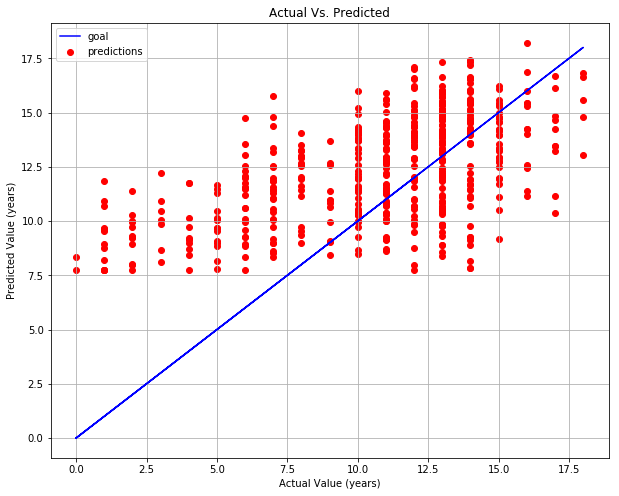

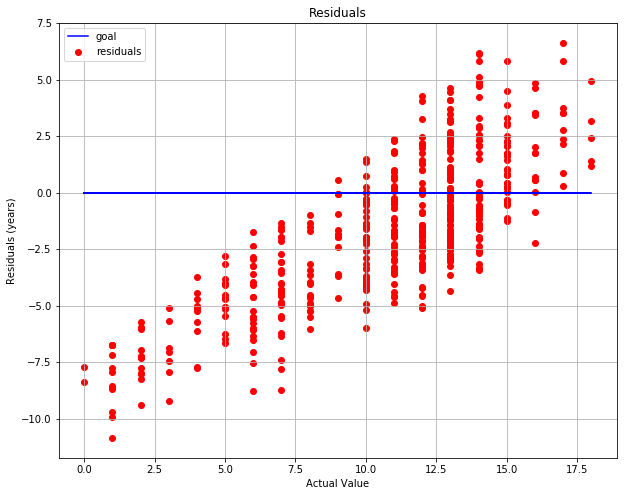

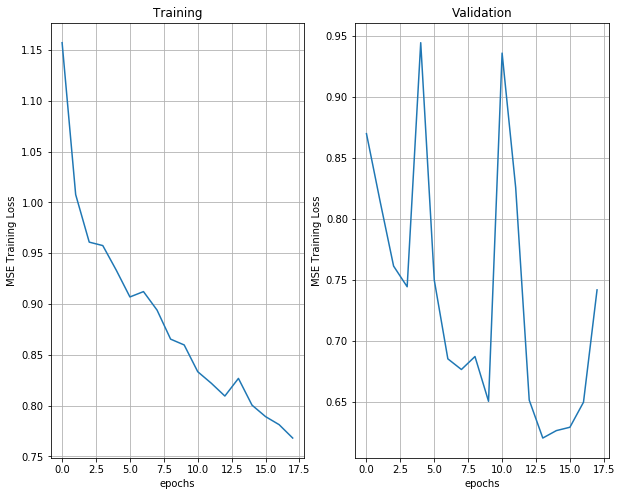

In [62]:
plot_regression(cnn_reg_new_2, X_test, y_test, history=history_reg_new_2)
cnns.update({'new2' : cnn_reg_new_2})

### Network-In-Network

In [38]:
cnn_reg_nin = Sequential()

cnn_reg_nin.add(Conv2D(filters=64, 
                       kernel_size=(3,3), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_nin.add(Conv2D(filters=64, 
                       kernel_size=(1,1), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_nin.add(MaxPooling2D((4,4), data_format='channels_last'))
cnn_reg_nin.add(Dropout(0.2))

cnn_reg_nin.add(Conv2D(filters=16, 
                       kernel_size=(3,3),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_nin.add(Conv2D(filters=16, 
                       kernel_size=(1,1),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_nin.add(MaxPooling2D((4,4), data_format='channels_last'))
cnn_reg_nin.add(Dropout(0.2))

cnn_reg_nin.add(Flatten())

cnn_reg_nin.add(Dense(units=64, 
                      activation='relu', 
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_reg)
                     ))
cnn_reg_nin.add(Dropout(0.2))
cnn_reg_nin.add(Dense(units=16, 
                      activation='relu', 
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_reg)
                     ))
cnn_reg_nin.add(Dropout(0.2))

cnn_reg_nin.add(Dense(units=1, activation='linear', kernel_initializer='glorot_uniform'))

cnn_reg_nin.compile(loss='mse',
                       optimizer='rmsprop')

history_reg_nin = cnn_reg_nin.fit_generator(datagen.flow(X_train, y_train, batch_size=1),
                             steps_per_epoch=int(X_train.shape[0]/1),
                             epochs=30,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='val_loss',
                                                      min_delta=0.01,
                                                      patience=4)])

Epoch 1/30
1500/1500 [==============================] - 12s 8ms/step - loss: 1.4587 - val_loss: 0.8869
Epoch 2/30
1500/1500 [==============================] - 11s 8ms/step - loss: 1.0132 - val_loss: 0.8320
Epoch 3/30
1500/1500 [==============================] - 11s 8ms/step - loss: 0.9439 - val_loss: 0.7591
Epoch 4/30
1500/1500 [==============================] - 11s 8ms/step - loss: 0.9098 - val_loss: 0.7308
Epoch 5/30
1500/1500 [==============================] - 11s 8ms/step - loss: 0.9128 - val_loss: 0.7176
Epoch 6/30
1500/1500 [==============================] - 11s 8ms/step - loss: 0.8706 - val_loss: 0.8874
Epoch 7/30
1500/1500 [==============================] - 11s 8ms/step - loss: 0.8572 - val_loss: 0.9680
Epoch 8/30
1500/1500 [==============================] - 11s 8ms/step - loss: 0.8525 - val_loss: 0.6725
Epoch 9/30
1500/1500 [==============================] - 11s 8ms/step - loss: 0.8464 - val_loss: 0.6729
Epoch 10/30
1500/1500 [==============================] - 11s 8ms/step - l

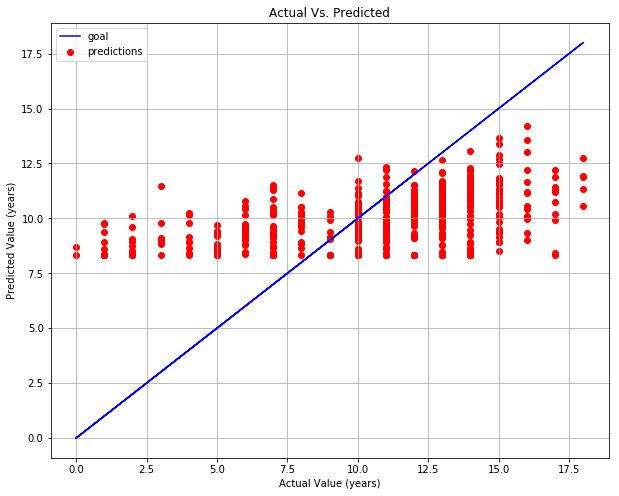

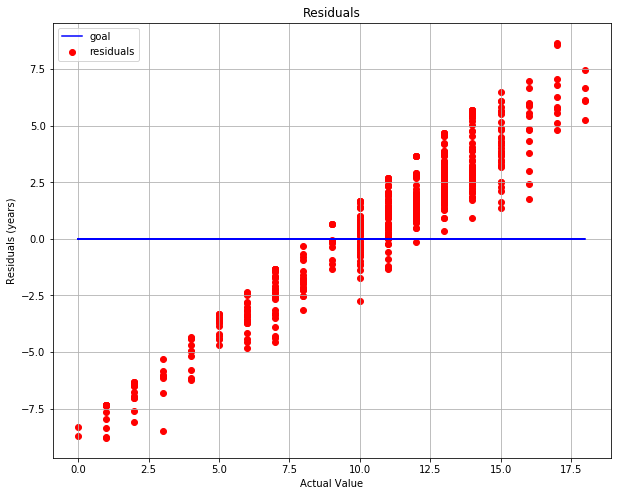

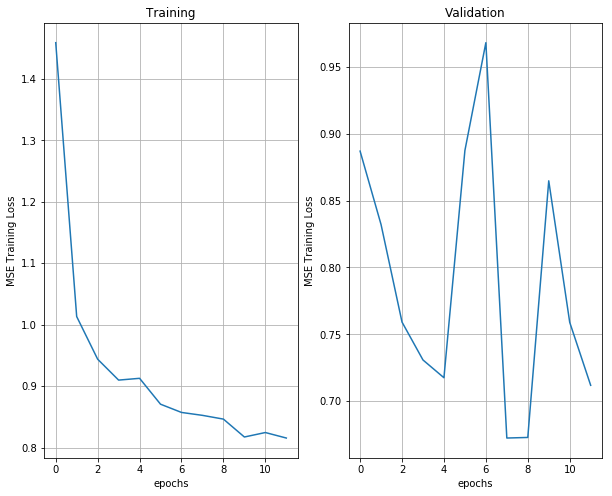

In [63]:
plot_regression(cnn_reg_nin, X_test, y_test, history=history_reg_nin)
cnns.update({'nin' : cnn_reg_nin})

Is it possible we've just discovered the secret sauce? This model seems to be doing much better, though it encounters some weird spikes every once in a while. We'll try one or two similar configurations.

In [40]:
cnn_reg_nin_1 = Sequential()

cnn_reg_nin_1.add(Conv2D(filters=64, 
                       kernel_size=(3,3), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_nin_1.add(Conv2D(filters=64, 
                       kernel_size=(1,1), 
                       input_shape=(img_dim, img_dim, 1), 
                       activation='relu',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_nin_1.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_reg_nin_1.add(Dropout(0.2))

cnn_reg_nin_1.add(Conv2D(filters=16, 
                       kernel_size=(3,3),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_nin_1.add(Conv2D(filters=16, 
                       kernel_size=(1,1),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_nin_1.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_reg_nin_1.add(Dropout(0.2))

cnn_reg_nin_1.add(Conv2D(filters=8, 
                       kernel_size=(3,3),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_nin_1.add(Conv2D(filters=8, 
                       kernel_size=(1,1),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       kernel_regularizer=l2(l2_reg)
                      ))
cnn_reg_nin_1.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_reg_nin_1.add(Dropout(0.2))

cnn_reg_nin_1.add(Flatten())

cnn_reg_nin_1.add(Dense(units=64, 
                      activation='relu', 
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_reg)
                     ))
cnn_reg_nin_1.add(Dropout(0.2))
cnn_reg_nin_1.add(Dense(units=16, 
                      activation='relu', 
                      kernel_initializer='he_uniform',
                      kernel_regularizer=l2(l2_reg)
                     ))
cnn_reg_nin_1.add(Dropout(0.2))

cnn_reg_nin_1.add(Dense(units=1, activation='linear', kernel_initializer='glorot_uniform'))

cnn_reg_nin_1.compile(loss='mse',
                       optimizer='rmsprop')

history_reg_nin_1 = cnn_reg_nin_1.fit_generator(datagen.flow(X_train, y_train, batch_size=1),
                             steps_per_epoch=int(X_train.shape[0]/1),
                             epochs=30,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='val_loss',
                                                      min_delta=0.01,
                                                      patience=4)])

Epoch 1/30
1500/1500 [==============================] - 14s 9ms/step - loss: 1.1914 - val_loss: 0.8775
Epoch 2/30
1500/1500 [==============================] - 13s 9ms/step - loss: 1.0005 - val_loss: 0.7539
Epoch 3/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.9183 - val_loss: 0.7423
Epoch 4/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.8696 - val_loss: 0.7226
Epoch 5/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.8556 - val_loss: 0.8085
Epoch 6/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.8365 - val_loss: 0.6886
Epoch 7/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.8251 - val_loss: 0.6707
Epoch 8/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.8093 - val_loss: 0.6562
Epoch 9/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.7992 - val_loss: 0.6420
Epoch 10/30
1500/1500 [==============================] - 13s 9ms/step - l

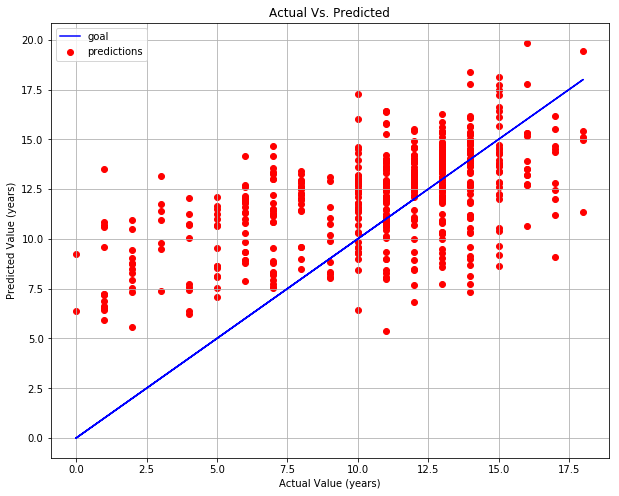

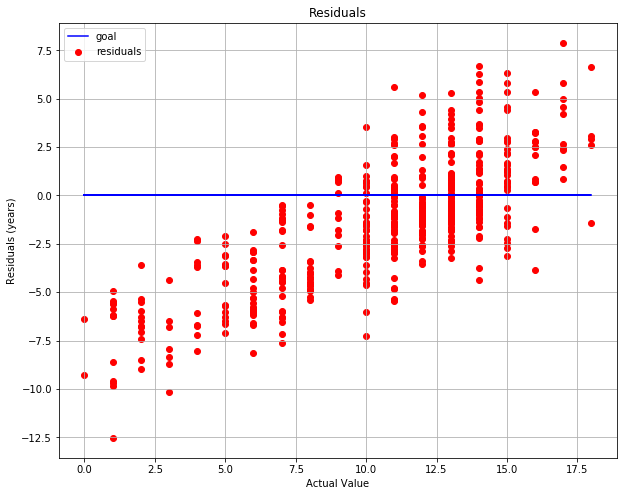

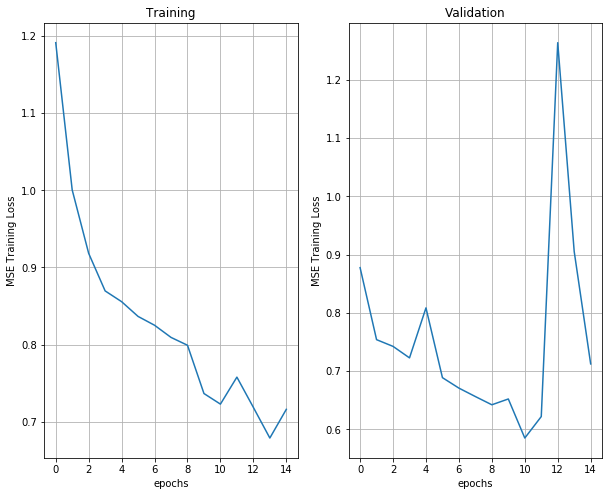

In [64]:
plot_regression(cnn_reg_nin_1, X_test, y_test, history=history_reg_nin_1)
cnns.update({'nin1': cnn_reg_nin_1})

This looks promising. This may be a good contender for the final model.

It also shouldn't go without mention that we have been going back and forth between different optimization strategies. Some of these models have been run multiple times, altering different quantities and things like the optimizer whenever the model simply crashes out and doesn't train.

## Cross-Validation to Determine Best Models

In [42]:
print('Models to Decide Between:')
print('=========================')

i=0
for name in cnns.keys():
    print('{}. {}'.format(i, name))
    print('=========================')
    i += 1

Models to Decide Between:
0. reg
1. tune
2. new
3. new1
4. new2
5. nin
6. nin1


In [65]:
cv = KFold(n_splits=3) # so that this doesn't take a year
all_scores = {}

for name, model in cnns.items():
    model.reset_states()
    model_scores = []
    
    for train_idx, cv_idx in cv.split(X_train, y_train):
        train_data = X_train[train_idx]
        train_target = y_train[train_idx]
        cv_data = X_train[cv_idx]
        cv_target = y_train[cv_idx]
        
        model.reset_states()
        
        print('====================')
        print('Training Model: {}'.format(name))
        print('====================')
        history = model.fit_generator(datagen.flow(train_data, train_target, batch_size=1),
                             steps_per_epoch=train_data.shape[0],
                             epochs=30,
                             verbose=1,
                             validation_data=(cv_data, cv_target),
                             callbacks=[EarlyStopping(monitor='val_loss',
                                                      patience=6)])
        model_scores.append(history.history['val_loss'][-1])
    all_scores.update({name : model_scores})

Training Model: reg
Epoch 1/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.8100 - val_loss: 0.7209
Epoch 2/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7853 - val_loss: 0.7636
Epoch 3/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.8104 - val_loss: 0.7262
Epoch 4/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7810 - val_loss: 0.7095
Epoch 5/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7873 - val_loss: 0.7908
Epoch 6/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7851 - val_loss: 0.7004
Epoch 7/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7860 - val_loss: 0.6992
Epoch 8/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7814 - val_loss: 0.7102
Epoch 9/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7422 - val_loss: 0.7152
Epoch 10/30
1000/1000 [==============================] - 8s 8m

Epoch 11/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7442 - val_loss: 0.6726
Epoch 12/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7538 - val_loss: 0.8044
Training Model: tune
Epoch 1/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7217 - val_loss: 0.8033
Epoch 2/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7093 - val_loss: 0.7077
Epoch 3/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7065 - val_loss: 0.7357
Epoch 4/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6987 - val_loss: 0.7496
Epoch 5/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6969 - val_loss: 0.9950
Epoch 6/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6975 - val_loss: 0.8790
Epoch 7/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6577 - val_loss: 0.7529
Epoch 8/30
1000/1000 [==============================] - 8s 

1000/1000 [==============================] - 8s 8ms/step - loss: 0.7414 - val_loss: 0.5759
Epoch 6/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6585 - val_loss: 0.6236
Epoch 7/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6833 - val_loss: 0.5437
Epoch 8/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6904 - val_loss: 0.5867
Epoch 9/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6673 - val_loss: 0.5847
Epoch 10/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6315 - val_loss: 0.5613
Epoch 11/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6633 - val_loss: 0.5326
Epoch 12/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6479 - val_loss: 0.5827
Epoch 13/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6423 - val_loss: 0.6109
Epoch 14/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6781 - val

1000/1000 [==============================] - 8s 8ms/step - loss: 0.7999 - val_loss: 0.6575
Epoch 11/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7890 - val_loss: 0.9698
Epoch 12/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7899 - val_loss: 0.6843
Epoch 13/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7841 - val_loss: 1.1253
Epoch 14/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7872 - val_loss: 0.6448
Epoch 15/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7410 - val_loss: 0.9526
Epoch 16/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7772 - val_loss: 0.7328
Epoch 17/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7490 - val_loss: 0.6762
Epoch 18/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7471 - val_loss: 0.6546
Epoch 19/30
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7845 -

1000/1000 [==============================] - 9s 9ms/step - loss: 0.5435 - val_loss: 0.5032
Epoch 6/30
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5696 - val_loss: 0.3375
Epoch 7/30
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5428 - val_loss: 0.4259
Epoch 8/30
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5542 - val_loss: 0.4177
Epoch 9/30
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5235 - val_loss: 0.3818
Epoch 10/30
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5098 - val_loss: 0.4535
Epoch 11/30
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4974 - val_loss: 0.3586
Epoch 12/30
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5504 - val_loss: 0.3743
Training Model: nin1
Epoch 1/30
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5451 - val_loss: 0.4204
Epoch 2/30
1000/1000 [==============================] - 9s 9ms/step -

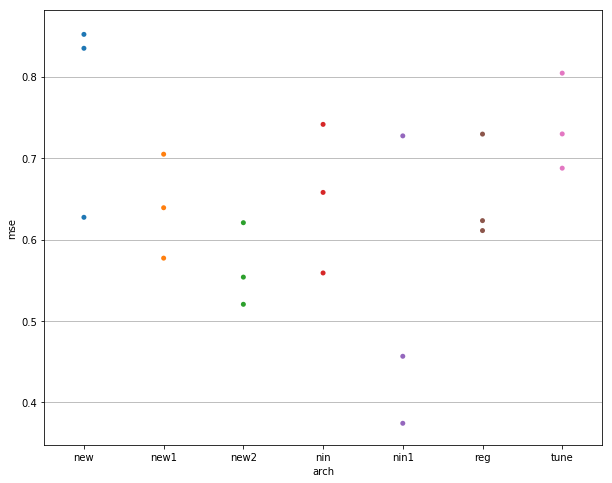

In [69]:
cv_df = pd.DataFrame(all_scores)
cv_df['run'] = cv_df.index

cv_melted = cv_df.melt(id_vars='run', 
                       value_vars=['new', 'new1', 'new2', 'nin', 'nin1', 'reg', 'tune'],
                       value_name='mse', var_name='arch')

sns.swarmplot(data=cv_melted, x='arch', y='mse')
plt.show()

### Prepare for Bad Statistics

Having only run three folds on each of these, it is hard to determine anything with statistical significance, so we will eyeball some of the better distributions and pick those to run in the full 10-fold validation. For this, we pick 'nin1' and 'new2.' Once we have those, we can apply more rigorous statistical methods.

In [72]:
cv = KFold(n_splits=10) # the full model now
all_scores = {}

model_picks = ['new2', 'nin1']

for name in model_picks:
    model = cnns[name]
    
    model.reset_states()
    model_scores = []
    
    print('======================')
    print('Training Model: {}'.format(name))
    print('======================')
    
    fold = 0
    
    for train_idx, cv_idx in cv.split(X_train, y_train):
        train_data = X_train[train_idx]
        train_target = y_train[train_idx]
        cv_data = X_train[cv_idx]
        cv_target = y_train[cv_idx]
        
        model.reset_states()
        
        print('======================')
        print('Training Fold: {} of {}'.format(fold, 10))
        print('======================')

        history = model.fit_generator(datagen.flow(train_data, train_target, batch_size=1),
                             steps_per_epoch=train_data.shape[0],
                             epochs=30,
                             verbose=1,
                             validation_data=(cv_data, cv_target),
                             callbacks=[EarlyStopping(monitor='val_loss',
                                                      patience=6)])
        model_scores.append(history.history['val_loss'][-1])
        fold += 1
        
    all_scores.update({name : model_scores})

Training Model: new2
Training Fold: 0 of 10
Epoch 1/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6744 - val_loss: 0.5516
Epoch 2/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6342 - val_loss: 0.6370
Epoch 3/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6103 - val_loss: 0.5002
Epoch 4/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6546 - val_loss: 0.4971
Epoch 5/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6278 - val_loss: 0.4932
Epoch 6/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6542 - val_loss: 0.5334
Epoch 7/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6465 - val_loss: 0.5614
Epoch 8/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6270 - val_loss: 0.5373
Epoch 9/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6267 - val_loss: 0.4893
Epoch 10/30
1350/1350 [===============

1350/1350 [==============================] - 9s 7ms/step - loss: 0.5728 - val_loss: 0.5411
Epoch 2/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.5843 - val_loss: 0.3937
Epoch 3/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.5823 - val_loss: 0.7445
Epoch 4/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6042 - val_loss: 0.2746
Epoch 5/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.5755 - val_loss: 0.3700
Epoch 6/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.5900 - val_loss: 0.3010
Epoch 7/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6106 - val_loss: 0.3691
Epoch 8/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.5806 - val_loss: 0.8393
Epoch 9/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6048 - val_loss: 0.4631
Epoch 10/30
1350/1350 [==============================] - 9s 7ms/step - loss: 0.6149 - val_los

1350/1350 [==============================] - 11s 8ms/step - loss: 0.4820 - val_loss: 0.3296
Epoch 3/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4805 - val_loss: 0.3113
Epoch 4/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4570 - val_loss: 0.3794
Epoch 5/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4828 - val_loss: 0.2802
Epoch 6/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4780 - val_loss: 0.3553
Epoch 7/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.5030 - val_loss: 0.2746
Epoch 8/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4507 - val_loss: 0.3641
Epoch 9/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4627 - val_loss: 0.2758
Epoch 10/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4781 - val_loss: 0.3128
Epoch 11/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.469

1350/1350 [==============================] - 11s 8ms/step - loss: 0.4321 - val_loss: 0.5202
Epoch 13/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4489 - val_loss: 0.2708
Epoch 14/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4274 - val_loss: 0.3393
Epoch 15/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4307 - val_loss: 0.3346
Epoch 16/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4487 - val_loss: 0.3038
Epoch 17/30
1350/1350 [==============================] - 11s 8ms/step - loss: 0.4622 - val_loss: 0.3752


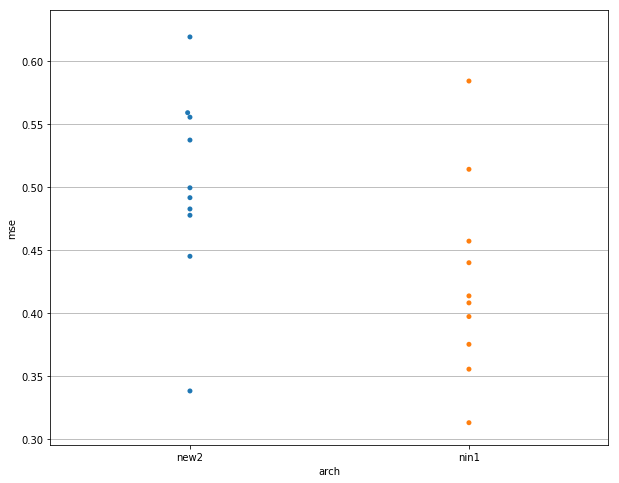

In [73]:
cv_df = pd.DataFrame(all_scores)
cv_df['run'] = cv_df.index

cv_melted = cv_df.melt(id_vars='run', 
                       value_vars=['new2', 'nin1'],
                       value_name='mse', var_name='arch')

sns.swarmplot(data=cv_melted, x='arch', y='mse')
plt.show()

In [75]:
cv_df

,new2,nin1,run
0,0.618899,0.408010,0
1,0.499267,0.355456,1
2,0.444958,0.456971,2
3,0.482482,0.413537,3
4,0.537130,0.439848,4
5,0.338156,0.397165,5
6,0.477481,0.312984,6
7,0.558829,0.513948,7
8,0.555268,0.583936,8
9,0.491437,0.375151,9


In [82]:
from scipy.stats import ttest_ind

_, pval = ttest_ind(cv_df['new2'], cv_df['nin1'], equal_var=True)

print('The p-value for testing the null hypothesis that nin1 is better than new2 is {}'.format(pval))

The p-value for testing the null hypothesis that nin1 is better than new2 is 0.04450957723282966


We detect statistical significance and choose nin1 as our preferred model.

## Comparison to MLP